# Análise de Dados de Vendas de Varejo

### Objetivo

O objetivo deste projeto é realizar uma análise detalhada dos dados de vendas de uma empresa de varejo. Com base nos dados fornecidos, serão realizadas as seguintes atividades:

1. Consolidação e tratamento das bases de dados.
2. Análises de faturamento vs. meta por vendedor, produto e cliente.
3. Cálculo de comissionamento de vendedores.
4. Diluição de metas diárias.
5. Projeção de faturamento futuro.
6. Implementação de algoritmos de clusterização.

#### Desafio 1: Análises no Power BI
1. Clientes
2. Vendedores
3. Produtos

#### Desafio 2: Análises em Python

1. **Clusterização de Clientes**
   - Implementar um algoritmo de clusterização (como K-means) para segmentar os clientes com base em seu comportamento de compra.
     
#### Ferramentas Utilizadas

- **Power BI:** Para visualizações interativas e análise de dados.
- **Python:** Para tratamento de dados, modelagem e análise de séries temporais.
- **Bibliotecas Python:** pandas, numpy, scikit-learn, statsmodels, matplotlib, seaborn.

#### Conclusão

Este projeto fornecerá insights valiosos sobre o desempenho de vendas da empresa, identificando áreas de melhoria e oportunidades de crescimento. As análises ajudarão a empresa a tomar decisões estratégicas baseadas em dados, otimizar suas operações e alcançar suas metas de faturamento.


In [457]:
import pandas as pd
import  numpy as np
import matplotlib.pyplot as plt  
import seaborn as sns

### Adicionando os arquivos

In [460]:
# Caminho para os arquivos
file_path = r'C:\Users\DSilva\Downloads\Desafio TDBUSINESS\\'

# Lista de arquivos de vendas
sales_files = [
    'Base_dez.22.xlsx',
    'Base_fev.23.xlsx',
    'Base_jan.23.xlsx',
    'Base_mai.23.xlsx',
    'Base_mar.23.xlsx',
    'Base_nov.22.xlsx',
    'Base_out.22.xlsx',
    'Base_abr.23.xlsx'
]

# Carregar os dados de vendas
sales_data = {file: pd.read_excel(file_path + file) for file in sales_files}

# Carregar os arquivos adicionais
cliente_vendedor = pd.read_excel(file_path + 'Cliente_Vendedor.xlsx')
custo_produto = pd.read_excel(file_path + 'Custo_Produto.xlsx')
metas = pd.read_excel(file_path + 'Metas.xlsx')

for name, df in sales_data.items():
    print(f"\n{name}:\n", df.head())

print("\nCliente_Vendedor:\n", cliente_vendedor.head())
print("\nCusto_Produto:\n", custo_produto.head())
print("\nMetas:\n", metas.head())


Base_dez.22.xlsx:
   Data Venda Nota Fiscal     Cliente    Produto  Quantidade
0 2022-12-01       NF506  Cliente 13  Produto F          36
1 2022-12-01       NF516  Cliente 20  Produto G          13
2 2022-12-01       NF528  Cliente 19  Produto A          18
3 2022-12-02       NF542   Cliente 6  Produto O          61
4 2022-12-02       NF554  Cliente 16  Produto I          26

Base_fev.23.xlsx:
   Data Venda Nota Fiscal     Cliente    Produto  Quantidade
0 2023-02-01       NF125  Cliente 16  Produto B          30
1 2023-02-01       NF137   Cliente 9  Produto I          99
2 2023-02-01       NF138   Cliente 2  Produto K           7
3 2023-02-01       NF184   Cliente 5  Produto N          19
4 2023-02-02       NF128  Cliente 10  Produto J          13

Base_jan.23.xlsx:
   Data Venda Nota Fiscal     Cliente    Produto  Quantidade
0 2023-01-01        NF15   Cliente 4  Produto G          70
1 2023-01-01        NF20   Cliente 5  Produto G          88
2 2023-01-01        NF72  Cliente 17  Pr

### Tratamento dos arquivos

In [462]:
# Carregar os dados de vendas em um único DataFrame
all_sales_data = []

for file in sales_files:
    df = pd.read_excel(file_path + file)
    all_sales_data.append(df)
    
sales_data_combined = pd.concat(all_sales_data, ignore_index=True) 

sales_data_combined['Data Venda'] = pd.to_datetime(sales_data_combined['Data Venda'])

sales_data_combined = sales_data_combined.sort_values(by='Data Venda').reset_index(drop=True)


In [464]:
cliente_vendedor[['Código Vendedor', 'Nome Vendedor']] = cliente_vendedor['Vendedor'].str.split(' - ', n=1, expand=True)

In [346]:
cliente_vendedor = cliente_vendedor.drop(columns=['Vendedor'])
cliente_vendedor = cliente_vendedor.drop(columns=['DataFim'])

In [325]:
# Excluir as quatro primeiras linhas
metas = metas.drop(index=metas.index[:4])
# Resetar o índice do DataFrame
metas.reset_index(drop=True, inplace=True)

In [352]:
new_column_names = {
    'Metas por Vendedor': 'Vendedor',
    'Unnamed: 1': 'out/22',
    'Unnamed: 2': 'nov/22',
    'Unnamed: 3': 'dez/22',
    'Unnamed: 4': 'jan/23',
    'Unnamed: 5': 'fev/23',
    'Unnamed: 6': 'mar/23',
    'Unnamed: 7': 'abr/23',
    'Unnamed: 8': 'mai/23'
}

metas = metas.rename(columns=new_column_names)

new_column_names = {
    'Nome Vendedor': 'Vendedor'}
cliente_vendedor = cliente_vendedor.rename(columns=new_column_names)

In [452]:
# Função para padronizar os nomes
def ajustar_nome(vendedor):
    # Remover números e traço
    nome = vendedor.split(' - ', 1)[-1]
    # Capitalizar corretamente o nome
    nome = nome.title()
    # Corrigir nomes específicos
    nome = nome.replace("Joao Augusto", "João Augusto")
    nome = nome.replace("Jose Antonio", "José Antônio")
    return nome

# Aplicar a função na coluna 'Vendedor'
metas['Vendedor'] = metas['Vendedor'].apply(ajustar_nome)

#### Merge na tabela de vendas

In [424]:
# Mesclar vendas com cliente_vendedor usando a coluna 'Cliente'
salesmerge = pd.merge(sales_data_combined, cliente_vendedor, on='Cliente', how='left')
salesmerge

salesmerge = pd.merge(salesmerge, custo_produto[['Produto', 'Categoria']], on='Produto', how='left')

# Transformar a tabela custo_produto para ter os meses como linhas
custo_produto_long = custo_produto.melt(id_vars=['Categoria', 'Produto'], var_name='Mes', value_name='Custo')

# Ajustar a coluna 'Mes' para que as datas sejam interpretadas corretamente
mes_translation = {
    'jan/23': '2023-01',
    'fev/23': '2023-02',
    'mar/23': '2023-03',
    'abr/23': '2023-04',
    'mai/23': '2023-05',
    'nov/22': '2022-11',
    'dez/22': '2022-12'
}
custo_produto_long['Mes'] = custo_produto_long['Mes'].replace(mes_translation)

# Converter a coluna 'Mes' para datetime
custo_produto_long['Mes'] = pd.to_datetime(custo_produto_long['Mes'], format='%Y-%m')

custo_produto_long['AnoMes'] = custo_produto_long['Mes'].dt.to_period('M')

salesmerge['AnoMes'] = salesmerge['Data Venda'].dt.to_period('M')

salesmerge = pd.merge(salesmerge, custo_produto_long[['Produto', 'AnoMes', 'Custo']], 
                      left_on=['Produto', 'AnoMes'], right_on=['Produto', 'AnoMes'], how='left')

salesmerge['Valor Vendido'] = salesmerge['Quantidade'] * salesmerge['Custo']

salesmerge


,Data Venda,Nota Fiscal,Cliente,Produto,Quantidade,AnoMes,Cidade,DataInicio,Comissao,Código Vendedor,Vendedor,Categoria,Custo,Valor Vendido
0,2022-10-01,NF1612,Cliente 12,Produto A,73,2022-10,São Paulo,2022-02-15,0.099,104,José Antônio,Cat1,NaN,NaN
1,2022-10-01,NF1631,Cliente 12,Produto M,9,2022-10,São Paulo,2022-02-15,0.099,104,José Antônio,Cat3,NaN,NaN
2,2022-10-01,NF1639,Cliente 10,Produto I,66,2022-10,São Paulo,2022-02-15,0.077,104,José Antônio,Cat4,NaN,NaN
3,2022-10-02,NF1604,Cliente 20,Produto D,65,2022-10,Teresina,2022-10-01,0.121,106,Marcos Silva,Cat1,NaN,NaN
4,2022-10-02,NF1584,Cliente 17,Produto C,80,2022-10,São Paulo,2022-05-10,0.077,101,Fábio Ferreira,Cat2,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
801,2023-05-28,NF289,Cliente 12,Produto C,51,2023-05,São Paulo,2022-02-15,0.099,104,José Antônio,Cat2,0.717986,36.617285
802,2023-05-29,NF335,Cliente 20,Produto B,55,2023-05,Teresina,2022-10-01,0.121,106,Marcos Silva,Cat1,3.191049,175.507683
803,2023-05-29,NF338,Cliente 16,Produto B,27,2023-05,Belo Horizonte,2022-05-10,0.055,101,Fábio Ferreira,Cat1,3.191049,86.158317
804,2023-05-29,NF341,Cliente 6,Produto E,86,2023-05,Recife,2022-10-01,0.100,105,Kleber Dias,Cat2,4.652549,400.119225


#### Ajustes na tabela metas

In [449]:
import pandas as pd

metas = pd.DataFrame({
    'Vendedor': ['Fábio Ferreira', 'Flávia Alessandra', 'João Augusto', 'José Antônio', 'Kléber Dias', 'Marcos Silva', 'Paulo Roberto', 'Total'],
    'out/22': [58978.394, 46391.92, 44843.192, 73177.398, 33960.144, 70875.282, 31392.332, 359618.662],
    'nov/22': [62082.52, 48833.6, 47203.36, 77028.84, 35747.52, 74605.56, 33044.56, 378545.96],
    'dez/22': [83827, 42683, 63034, 85773, 31293, 61722, 34297, 402629],
    'jan/23': [67463, 48671, 48365, 78540, 41513, 71165, 36696, 392413],
    'fev/23': [62887, 51785, 62123, 85664, 39622, 61112, 36386, 399579],
    'mar/23': [59769, 39074, 47653, 84936, 31979, 54167, 35740, 353318],
    'abr/23': [63395, 51654, 50200, 80944, 44727, 86742, 31058, 408720],
    'mai/23': [77953, 40728, 65920, 77457, 40272, 76288, 39985, 418603]
})

metas = metas[metas['Vendedor'] != 'Total']

# Transformar os meses em uma única coluna
metas_long = metas.melt(id_vars=['Vendedor'], var_name='Mês', value_name='Meta')

mes_translation = {
    'out/22': '2022-10',
    'nov/22': '2022-11',
    'dez/22': '2022-12',
    'jan/23': '2023-01',
    'fev/23': '2023-02',
    'mar/23': '2023-03',
    'abr/23': '2023-04',
    'mai/23': '2023-05'
}
metas_long['Mês'] = metas_long['Mês'].replace(mes_translation)

print(metas_long.head())

            Vendedor      Mês       Meta
0     Fábio Ferreira  2022-10  58978.394
1  Flávia Alessandra  2022-10  46391.920
2       João Augusto  2022-10  44843.192
3       José Antônio  2022-10  73177.398
4        Kléber Dias  2022-10  33960.144


### Exportação dos arquivos excel 

In [446]:
import os

#pasta para os arquivos tratados
treated_files_path = file_path + 'Treated_Files\\'
os.makedirs(treated_files_path, exist_ok=True)

salesmerge.to_excel(treated_files_path + 'Sales_Merge.xlsx', index=False)
cliente_vendedor.to_excel(treated_files_path + 'Cliente_Vendedor_Tratado.xlsx', index=False)
custo_produto.to_excel(treated_files_path + 'Custo_Produto_Tratado.xlsx', index=False)
metas_long.to_excel(treated_files_path + 'Metas_Ajustadas.xlsx', index=False)


# Desafio 2

1. Implemente um algoritmo de clusterização (como K-means) para segmentar os clientes com base em seu comportamento de compra. Utilize métricas como frequência de compra, valor médio de pedido e recência da última compra. Visualize os clusters em um gráfico de dispersão 3D e forneça insights sobre as características de cada grupo de clientes.

In [130]:
import pandas as pd
import numpy as np
from datetime import datetime

### Adicionando os arquivos

In [413]:
# Caminho para os arquivos
file_path = r'C:\Users\DSilva\Downloads\Desafio TDBUSINESS\Treated_Files\\'

# Lista de arquivos 
cvendedor = pd.read_excel(file_path + 'Cliente_Vendedor_Tratado.xlsx')
cproduto = pd.read_excel(file_path + 'Custo_Produto_Tratado.xlsx')
metas = pd.read_excel(file_path + 'Metas_Ajustadas.xlsx')
vendas = pd.read_excel(file_path + 'Sales_Data_Combined.xlsx')

### Métricas e integrações

In [194]:
vendas['Data Venda'] = pd.to_datetime(vendas['Data Venda'])

# Adicionar uma coluna 'ValorVenda' com base nos dados de custo do produto
def obter_valor_venda(row):
    mes_ano = row['Data Venda'].strftime('%b/%y').lower()
    if mes_ano in cproduto.columns:
        return cproduto.loc[cproduto['Produto'] == row['Produto'], mes_ano].values[0]
    return 0

vendas['ValorVenda'] = vendas.apply(obter_valor_venda, axis=1) * vendas['Quantidade']

# Calcular a métrica de recência
latest_date = vendas['Data Venda'].max()
recency = vendas.groupby('Cliente')['Data Venda'].apply(lambda x: (latest_date - x.max()).days).reset_index()
recency.columns = ['Cliente', 'Recencia']

# Calcular a métrica de frequência
frequency = vendas.groupby('Cliente')['Nota Fiscal'].count().reset_index()
frequency.columns = ['Cliente', 'Frequencia']

# Calcular o valor monetário
monetary = vendas.groupby('Cliente')['ValorVenda'].sum().reset_index()
monetary.columns = ['Cliente', 'ValorMonetario']

# Combinar todas as métricas em um único DataFrame
rfm = recency.merge(frequency, on='Cliente').merge(monetary, on='Cliente')

rfm

,Cliente,Recencia,Frequencia,ValorMonetario
0,Cliente 1,0,36,3884.807327
1,Cliente 10,3,42,5274.670271
2,Cliente 11,3,55,5233.648124
3,Cliente 12,2,41,4632.339776
4,Cliente 13,2,34,2752.068998
5,Cliente 14,5,23,2249.166003
6,Cliente 15,29,42,2696.092012
7,Cliente 16,1,48,6540.009665
8,Cliente 17,4,32,3134.025989
9,Cliente 18,4,36,1746.415077


In [437]:
# Integrar cvendedor ao DataFrame rfm
rfm = rfm.merge(cvendedor[['Cliente', 'Vendedor']], on='Cliente', how='left')

In [441]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Padronizar as features
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recencia', 'Frequencia', 'ValorMonetario']])

# Aplicar o algoritmo de K-means
kmeans = KMeans(n_clusters=3, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Calcular a pontuação silhouette para avaliar a qualidade dos clusters
silhouette_avg = silhouette_score(rfm_scaled, rfm['Cluster'])

C:\Users\DSilva\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


### Plotagem do gráfico


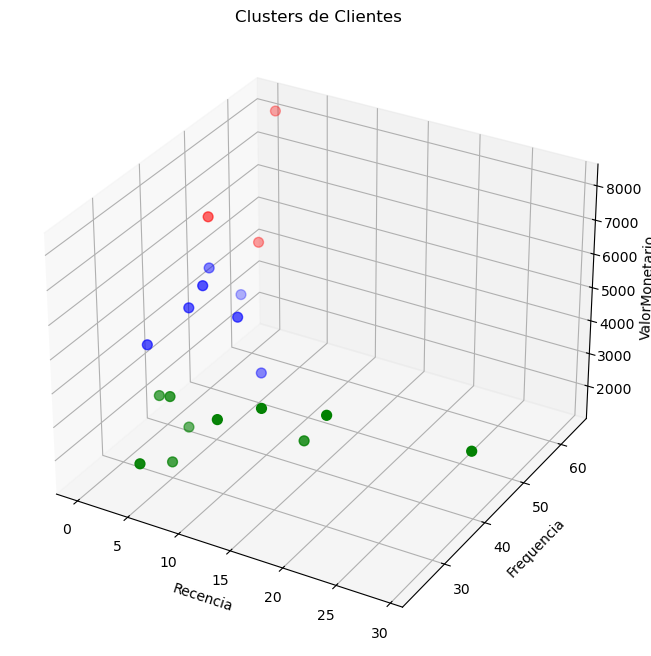

In [266]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def criar_grafico_3d(rfm):
    colors = ['r', 'g', 'b']
    rfm['Color'] = rfm['Cluster'].map({0: 'r', 1: 'g', 2: 'b'})

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.scatter(rfm['Recencia'], rfm['Frequencia'], rfm['ValorMonetario'], c=rfm['Color'], s=50)
    
    ax.set_xlabel('Recencia')
    ax.set_ylabel('Frequencia')
    ax.set_zlabel('ValorMonetario')
    
    plt.title('Clusters de Clientes')
    
    return fig, ax

fig, ax = criar_grafico_3d(rfm)

plt.show()

### Calcular as médias das métricas para cada cluster


In [246]:
cluster_summary = rfm.groupby('Cluster').agg({
    'Recencia': 'mean',
    'Frequencia': 'mean',
    'ValorMonetario': 'mean',
    'Cliente': 'count'
}).reset_index()

cluster_summary = cluster_summary.rename(columns={'Cliente': 'NumeroDeClientes'})

print(cluster_summary)

   Cluster   Recencia  Frequencia  ValorMonetario  NumeroDeClientes
0        0   1.666667   55.666667     6638.241255                 3
1        1  10.500000   33.000000     2680.923885                10
2        2   3.000000   44.142857     4228.604801                 7


### Formatação da tabela para visualização 

In [ ]:
# Arredondar os valores para 2 casas decimais
cluster_summary['Recencia'] = cluster_summary['Recencia'].round(2)
cluster_summary['Frequencia'] = cluster_summary['Frequencia'].round(2)
cluster_summary['ValorMonetario'] = cluster_summary['ValorMonetario'].round(2)
cluster_summary['NumeroDeClientes'] = cluster_summary['NumeroDeClientes'].round(0).astype(int)

# Renomear as colunas
cluster_summary = cluster_summary.rename(columns={
    'Recencia': 'Recência',
    'Frequencia': 'Frequência',
    'ValorMonetario': 'Valor monetário',
    'NumeroDeClientes': 'Número de clientes'
})

# Criar a tabela usando PrettyTable
table = PrettyTable()
table.field_names = cluster_summary.columns.tolist()

for index, row in cluster_summary.iterrows():
    table.add_row(row.tolist())

print(table)

# Análise dos Resultados da Clusterização K-means


#### Introdução

Utilizei o algoritmo de clusterização K-means para segmentar os clientes de acordo com seu comportamento de compra, baseado em três métricas:

Recência: Dias desde a última compra.

Frequência: Número total de compras realizadas.

Valor Monetário: Valor total gasto.

### Resultados dos Clusters
Os resultados dos clusters são os seguintes:

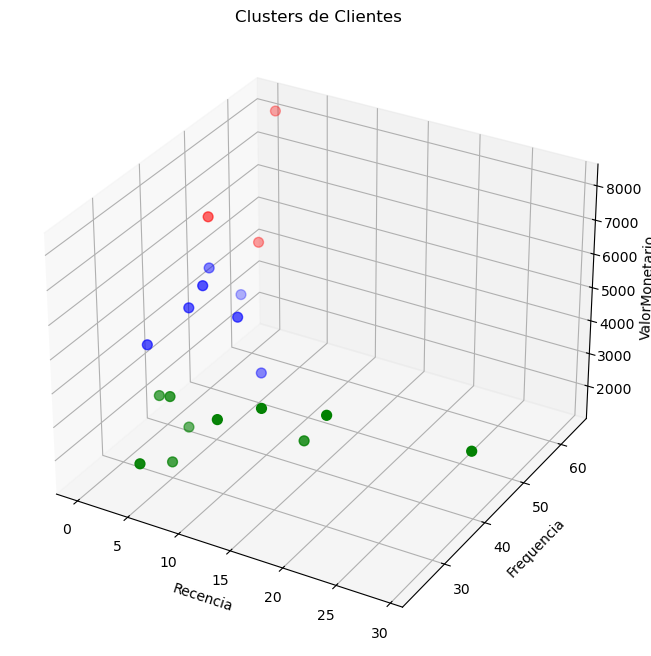

In [276]:
plt.show(criar_grafico_3d(rfm))

In [258]:
print(table)

+---------+----------+------------+-----------------+--------------------+
| Cluster | Recência | Frequência | Valor monetário | Número de clientes |
+---------+----------+------------+-----------------+--------------------+
|   0.0   |   1.67   |   55.67    |     6638.24     |        3.0         |
|   1.0   |   10.5   |    33.0    |     2680.92     |        10.0        |
|   2.0   |   3.0    |   44.14    |      4228.6     |        7.0         |
+---------+----------+------------+-----------------+--------------------+


### Características dos Clusters

##### Cluster 0: Clientes Altamente Ativos e Valiosos

Recência Média: 1.67 dias

Frequência Média: 55.67 compras

Valor Monetário Médio: 6638.24

Número de Clientes: 3

Descrição: Este cluster é composto por clientes que são altamente ativos e têm um alto valor de compra. Com uma recência média de 1.67 dias, esses clientes compram com muita frequência e gastam significativamente.

##### Cluster 1: Clientes Moderadamente Ativos

Recência Média: 10.5 dias

Frequência Média: 33.0 compras

Valor Monetário Médio: 2680.92

Número de Clientes: 10

Descrição: Este cluster representa clientes que são moderadamente ativos. Eles compram com uma frequência menor e têm um valor de compra médio. A recência média de 10.5 dias indica que esses clientes não são tão engajados, apesar de terem frequência.

##### Cluster 2: Clientes Ativos

Recência Média: 3 dias

Frequência Média: 44.14 compras

Valor Monetário Médio: 4228.60

Número de Clientes: 7

Descrição: Este cluster é composto por clientes que são bastante ativos, com uma recência média de 3 dias. Eles compram frequentemente e têm um valor de compra significativo, embora não tão alto quanto os do Cluster 0.

#### Conclusão

A clusterização revelou importantes insights sobre o comportamento de compra dos clientes, permitindo a identificação de grupos com características distintas. No entanto, para fornecer sugestões mais precisas e eficazes, seria benéfico ter acesso a informações adicionais, por exemplo:

Informações sobre o Produto: Dados detalhados sobre os produtos ou serviços comprados, incluindo características como marca, modelo, especificações técnicas, preços históricos, e disponibilidade. Isso pode ajudar a identificar tendências de compra e preferências de produtos específicos.

Histórico Completo de Compras: Informações sobre produtos específicos comprados, categorias de produtos, e datas de compra.

Preferências e Comportamentos de Navegação (se for compra online): Dados sobre as preferências de produtos e comportamento de navegação no site.

Dados Demográficos: Informações demográficas adicionais como idade, gênero e localização geográfica para segmentações mais precisas.

Feedback do Cliente: Comentários e avaliações dos clientes sobre produtos e serviços para entender melhor suas necessidades e expectativas.

Com essas informações adicionais, seria possível desenvolver estratégias de marketing e vendas ainda mais direcionadas e personalizadas, aumentando a satisfação do cliente e otimizando o valor de vida do cliente.







